# Group 1 - Project Report 

*By Sylvia Ying, Xiaolei Lin, and Erin Kang*

## Introduction
Attending university is an important stage of one’s academic journey. However, not every student obtains a degree, in which their dropout can be caused by a variety of factors. Predicting chances for academic success can be vital towards the future of both the student and university in considering whether the student should continue their studies. The dataset “Predict students' dropout and academic success” contains different factors, such as students’ gender and grades, that may contribute towards students’ status of becoming a graduate or a dropout. The goal is to see if students’ gender, age at enrollment, first year’s first and second semester grades are collectively a good predictor in determining the academic status of university students (graduate or dropout).  

## Process

1. Load necessary packages for analysis.  

In [1]:
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(cowplot)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

2. Set the seed for the analysis to be reproducible, and then read the data into R.\
Tidy and wrangle the data by converting the ‘Target’ vector to a factor from a character, choosing only the predictors of interest, and renaming them into more human-readable forms. 

In [50]:
set.seed(1)

data_set<- read_csv("https://raw.githubusercontent.com/ekang27kc/dsci100-2023-T2-Group01-project/main/dataset.csv")
my_data <- data_set |> 
    select(`Gender`, `Age at enrollment`, `Curricular units 1st sem (grade)`, 
           `Curricular units 2nd sem (grade)`, `Target`) |>
    filter(Target != "Enrolled") |>
    mutate(Target = factor(Target, levels = c("Dropout", "Graduate")))
colnames(my_data) <- c('gender', 'enrollment_age', 'first_semester_grade', 'second_semester_grade', 'status') # rename

head(my_data)

Rows: 4424 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Target
dbl (34): Marital status, Application mode, Application order, Course, Dayti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender,enrollment_age,first_semester_grade,second_semester_grade,status
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,20,0.00000,0.00000,Dropout
1,19,14.00000,13.66667,Graduate
1,19,0.00000,0.00000,Dropout
0,20,13.42857,12.40000,Graduate
0,45,12.33333,13.00000,Graduate
1,50,11.85714,11.50000,Graduate


**Figure 1:** Tidied and Wrangled Dataframe of “Predict students' dropout and academic success” Dataset

3. Split the tidied data set into a training and testing dataset. 

In [25]:
set.seed(1)

# split data, create training data and testing data
data_split <- initial_split(my_data, prop = 0.75, strata = status)
data_train <- training(data_split)   
data_test <- testing(data_split)

### Preliminary Analysis

In [4]:
summary_table <- data_train |>
    group_by(status) |>
    summarize(status_count = n(),
              female_count = sum(gender == 0),
              male_count = sum(gender == 1),
              mean_enrollment_age = mean(enrollment_age, na.rm = TRUE),
              mean_first_semester_grade = mean(first_semester_grade, na.rm = TRUE),
              mean_second_semester_grade = mean(second_semester_grade, na.rm = TRUE),
              missing_data = sum(is.na(enrollment_age), is.na(first_semester_grade), is.na(second_semester_grade)))
summary_table

status,status_count,female_count,male_count,mean_enrollment_age,mean_first_semester_grade,mean_second_semester_grade,missing_data
<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
Dropout,1065,547,518,26.15681,7.328979,5.812974,0
Graduate,1656,1229,427,21.76208,12.594641,12.635296,0


**Figure 2:** `insert title/figure explanation` 

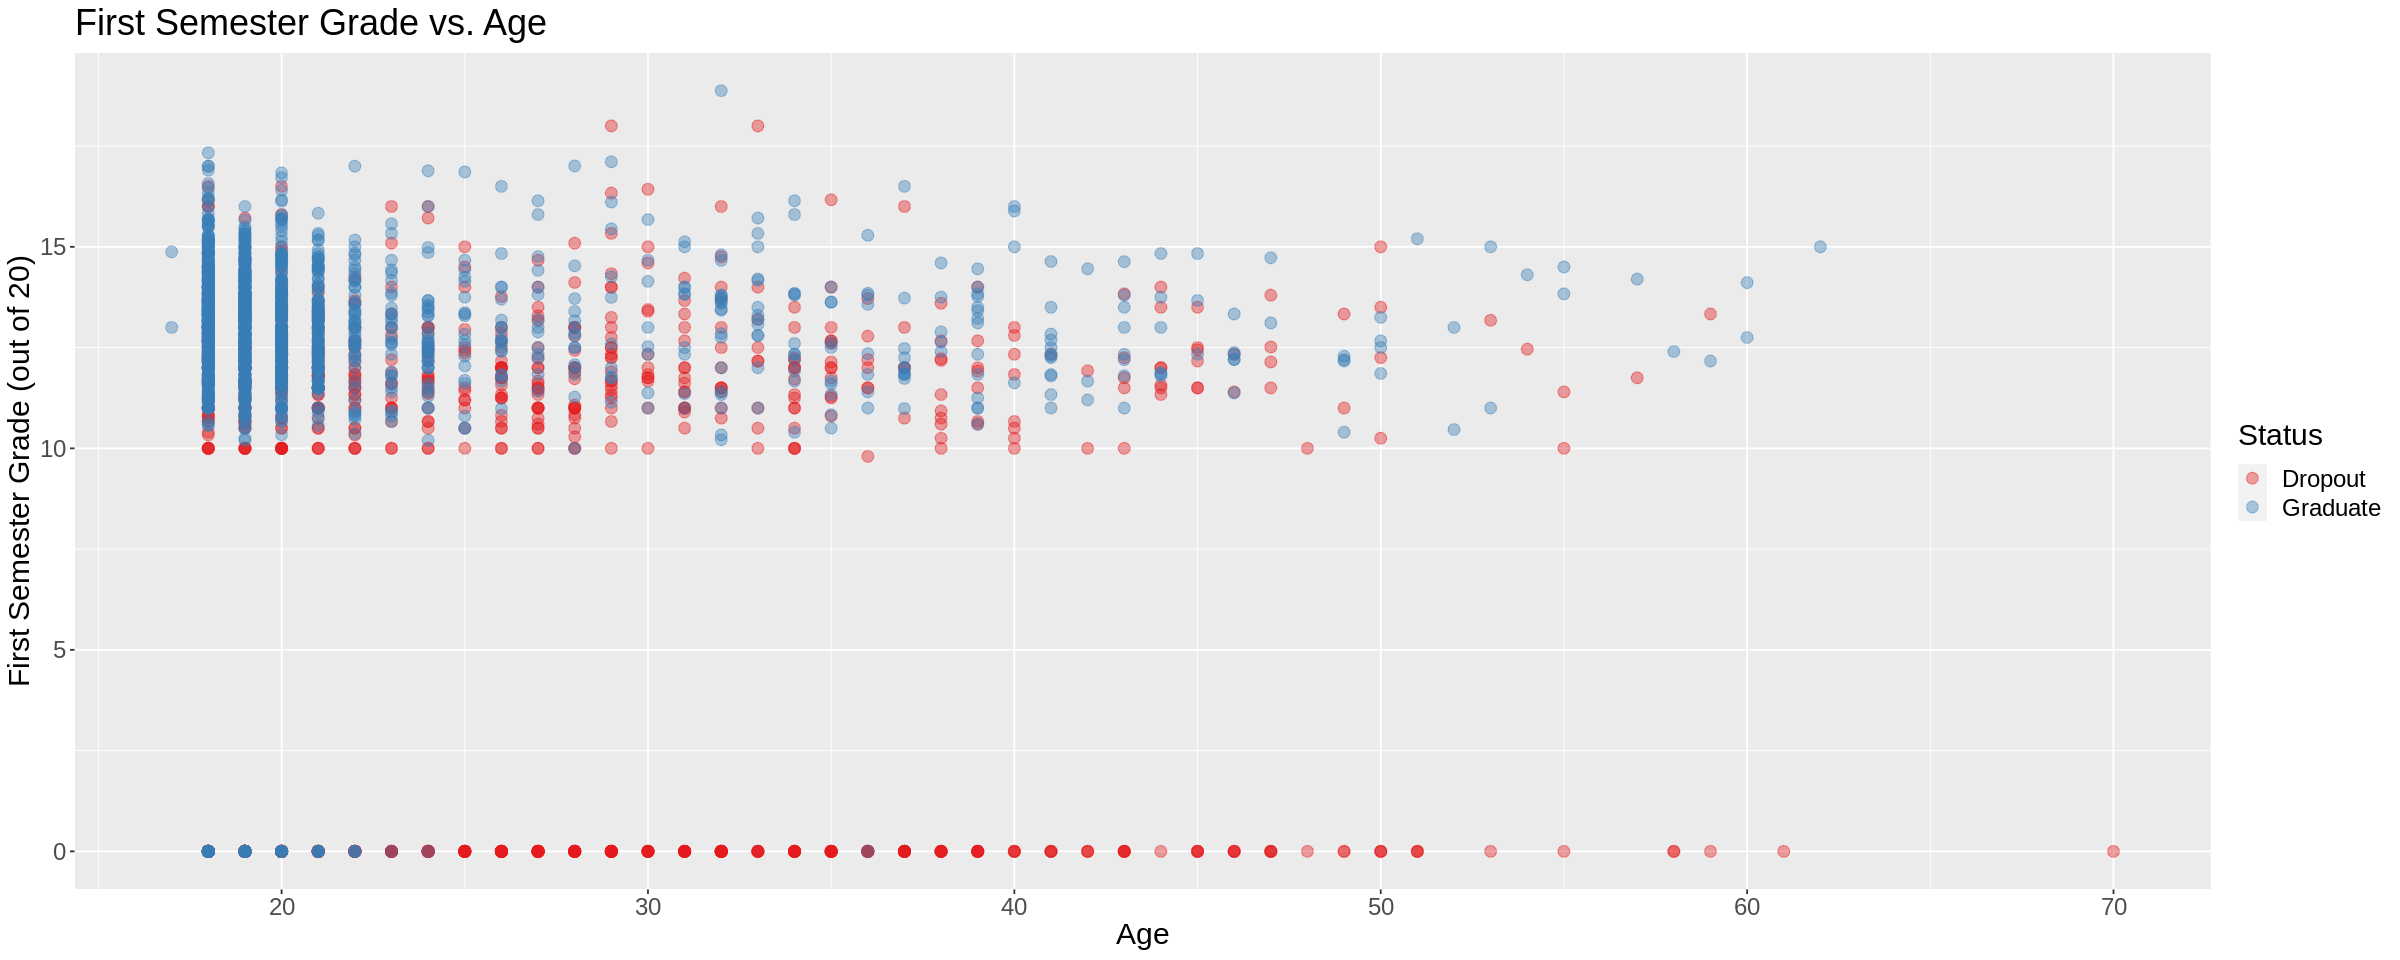

In [46]:
# graph 1: first semester grade vs. age 
# graph 2: second semester grade vs. age

options(repr.plot.width = 20, repr.plot.height = 8)
plot_one <- ggplot(data_train,
                   aes(x = enrollment_age, y = first_semester_grade, colour = status)) +
                           geom_point(alpha=0.4, size=3) +
                           labs(x = "Age", y = "First Semester Grade (out of 20)", title = "First Semester Grade vs. Age",
                                colour = "Status") +
                        scale_color_brewer(palette = "Set1")+
                           theme(text = element_text(size = 18))
plot_one


**Figure 3:** `insert figure explanation` 

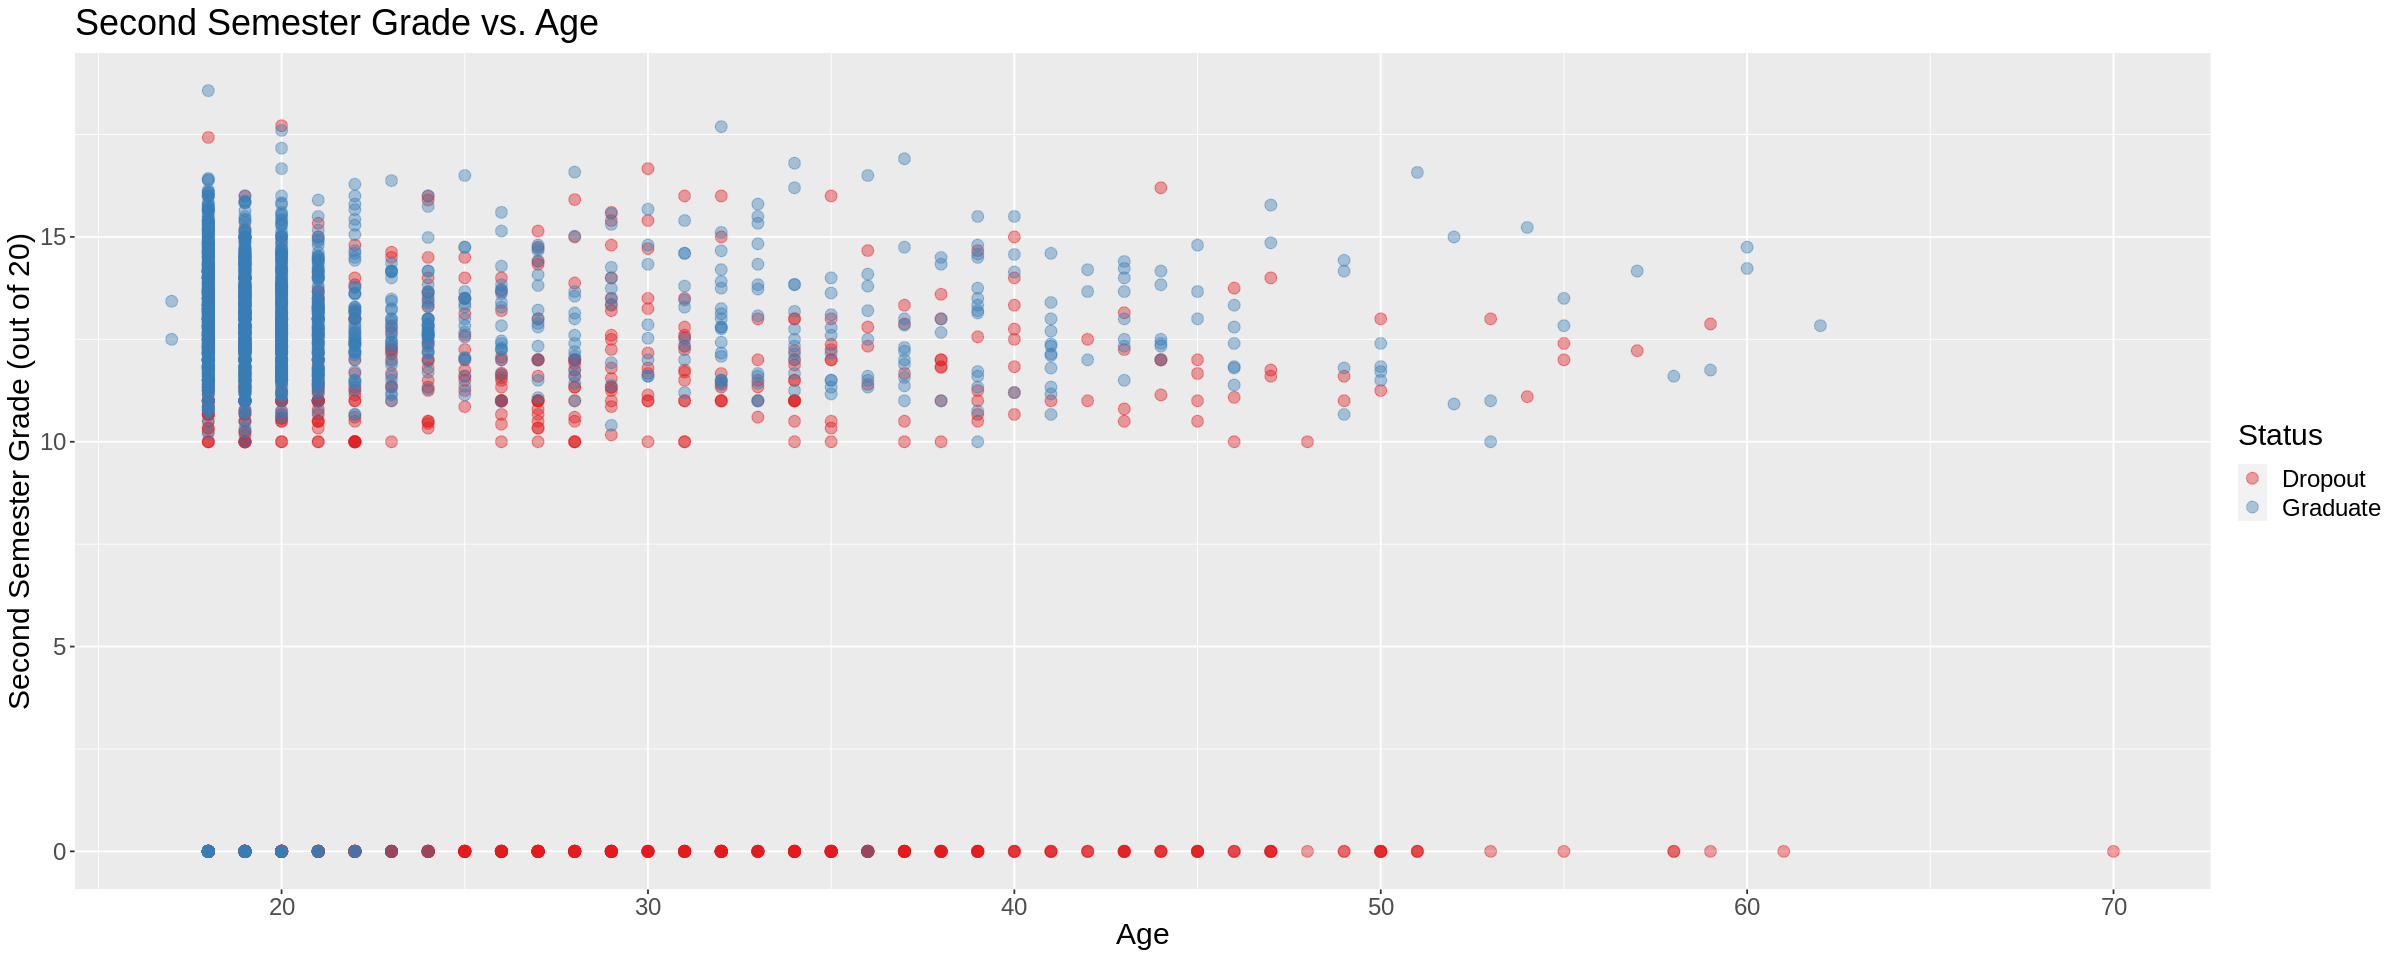

In [47]:
plot_two <- ggplot(data_train,
                   aes(x = enrollment_age, y = second_semester_grade, colour = status)) +
                           geom_point(alpha = 0.4, size = 3) + 
                           labs(x = "Age", y = "Second Semester Grade (out of 20)", title = "Second Semester Grade vs. Age",
                                colour = "Status") +
                            scale_color_brewer(palette = "Set1")+
                           theme(text = element_text(size = 18))
plot_two

**Figure 4:** `insert figure explanation` 

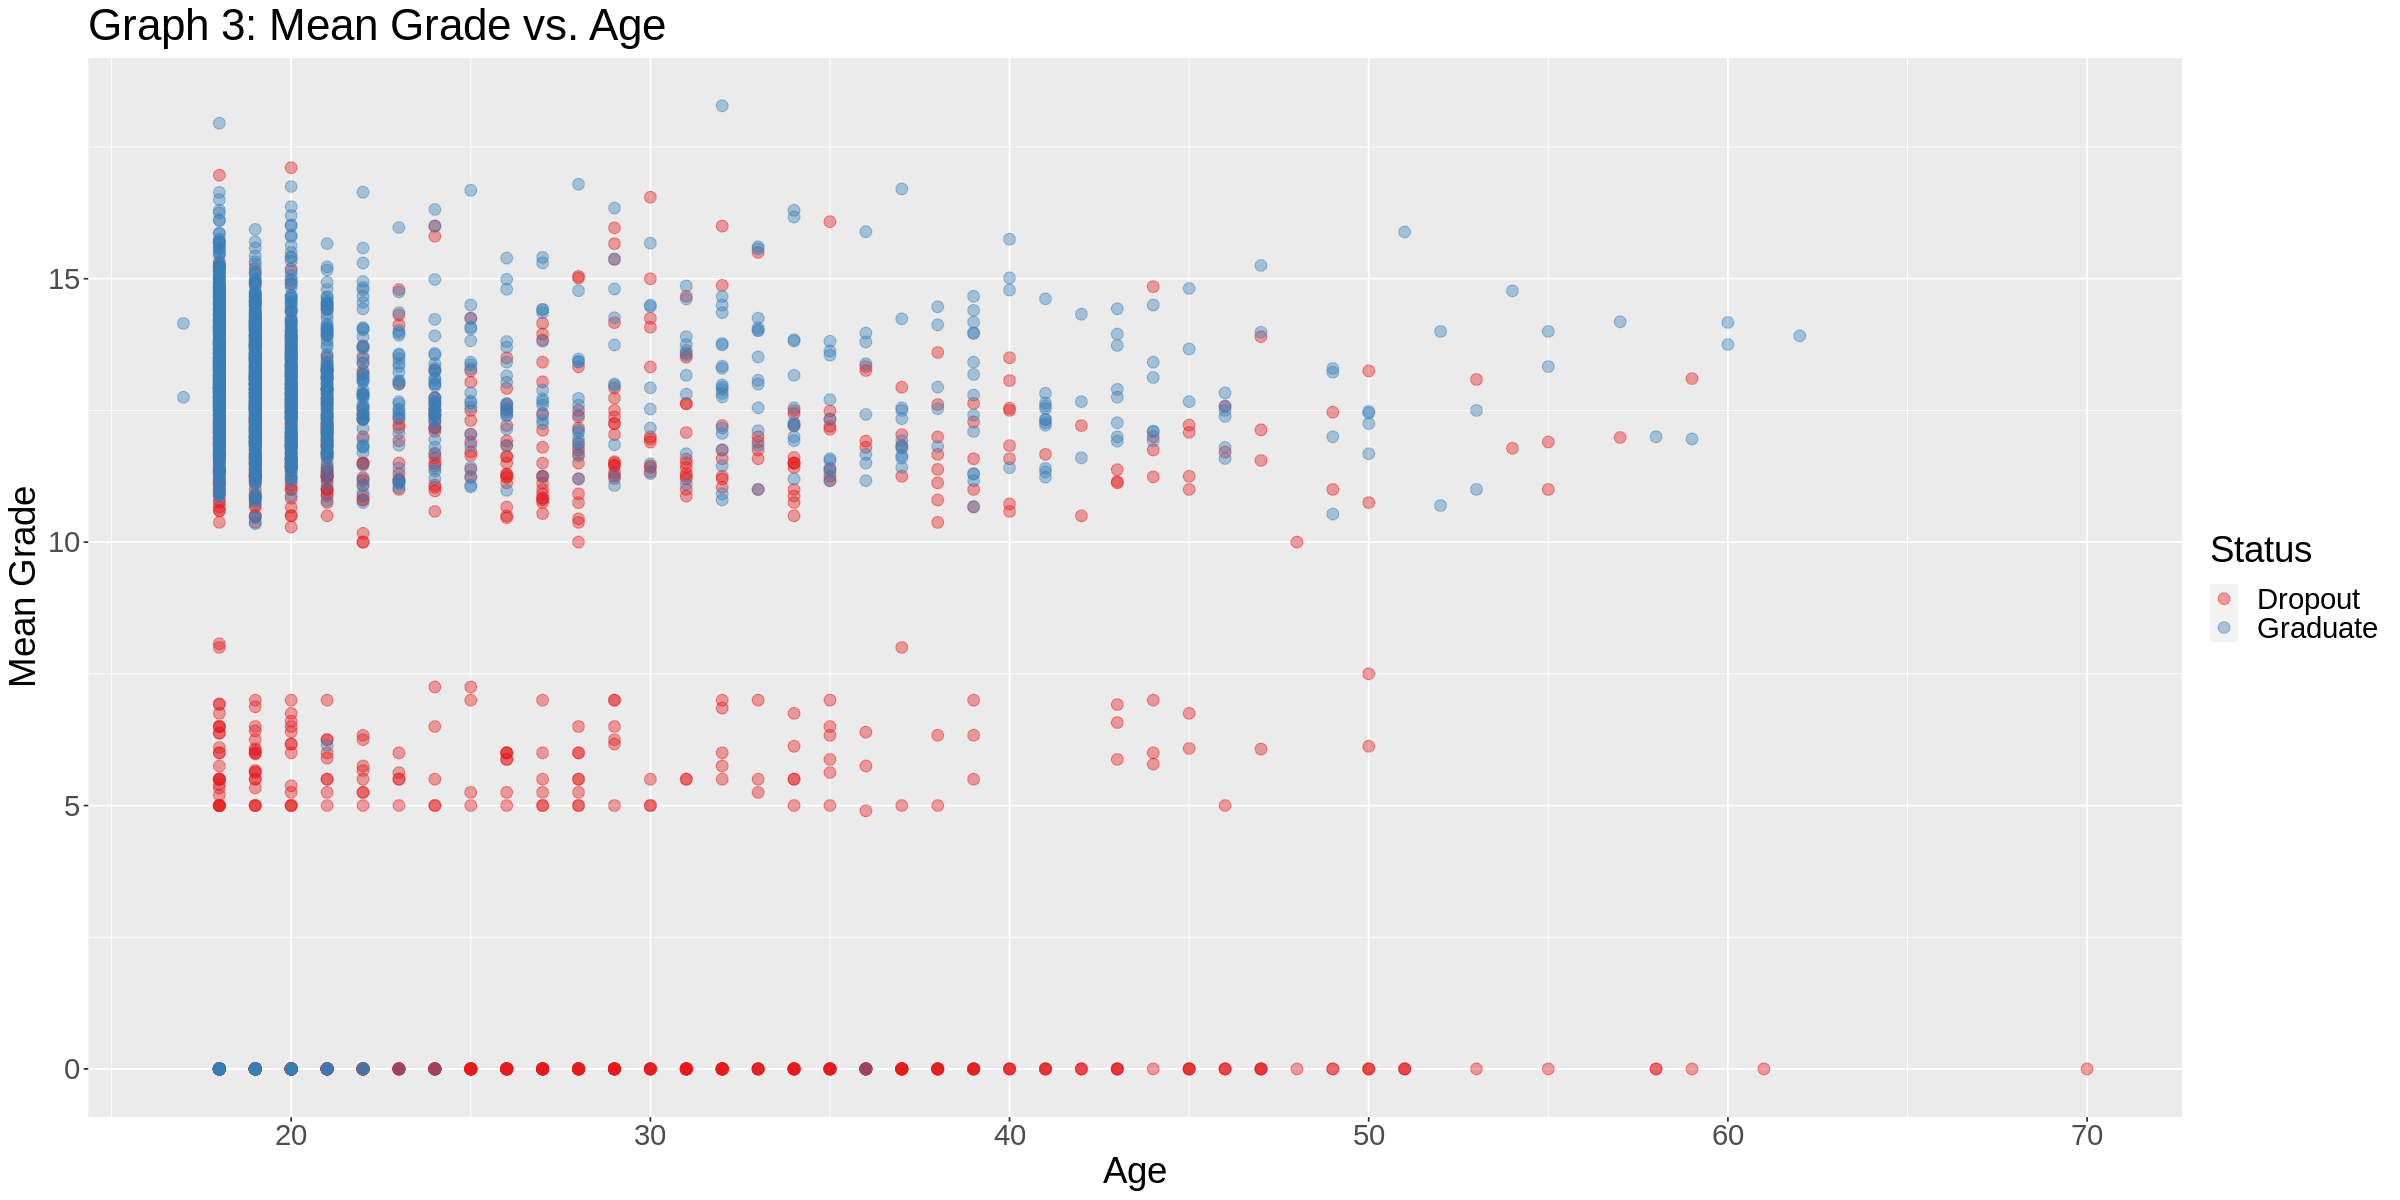

In [48]:
# graph 3: mean grade for the first and second semesters vs. age

options(repr.plot.width = 20, repr.plot.height = 10)

mean_grade_plot <- data_train |>
    mutate(mean_sem_grade = (first_semester_grade + second_semester_grade) / 2) |>
    ggplot(aes(x = enrollment_age, y = mean_sem_grade, colour = status)) +
    geom_point(alpha=0.4, size = 3) +
    labs(x = "Age", y = "Mean Grade", title = "Graph 3: Mean Grade vs. Age",
         colour = "Status") +
        scale_color_brewer(palette = "Set1")+
    theme(text = element_text(size = 22))
mean_grade_plot

 **Figure 5:** `insert figure explanation` 

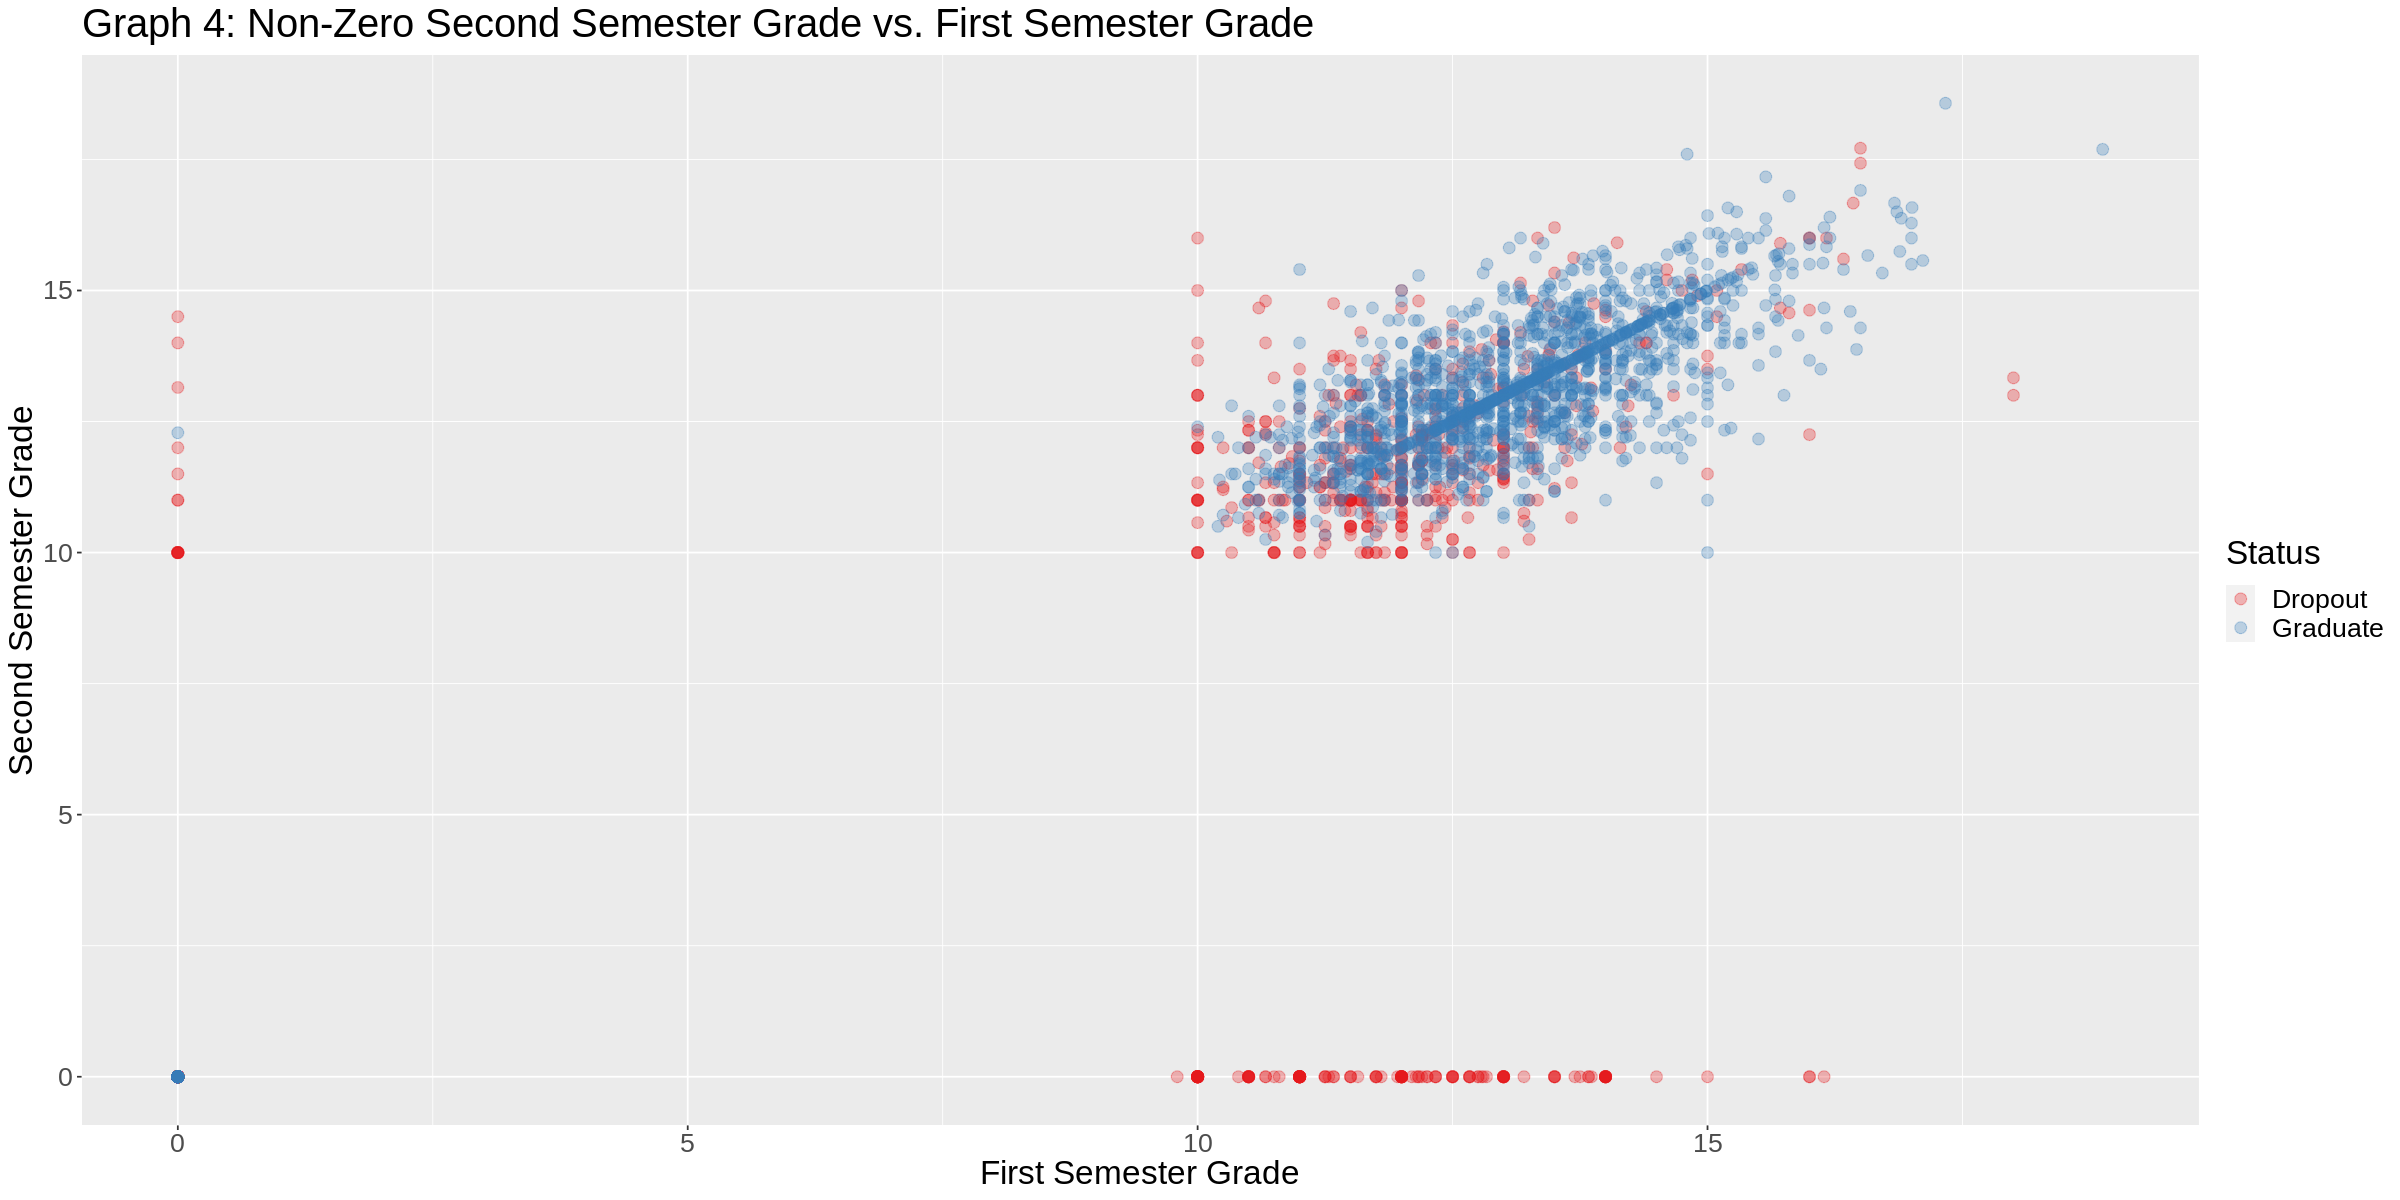

In [9]:
# graph 4: second semester grade vs. first semester grade
options(repr.plot.width = 20, repr.plot.height = 10)
grade_plot <- ggplot(data_train, 
                     aes(x = first_semester_grade, y = second_semester_grade, colour = status)) +
    geom_point(alpha = 0.3, size=3) +
    labs(x = "First Semester Grade", y = "Second Semester Grade", 
         title = "Graph 4: Non-Zero Second Semester Grade vs. First Semester Grade",
         colour = "Status") +
          scale_color_brewer(palette = "Set1")+
    theme(text = element_text(size = 20))
grade_plot

**Figure 6:** `insert figure explanation` 
Explain why y-axis starts from 10! 

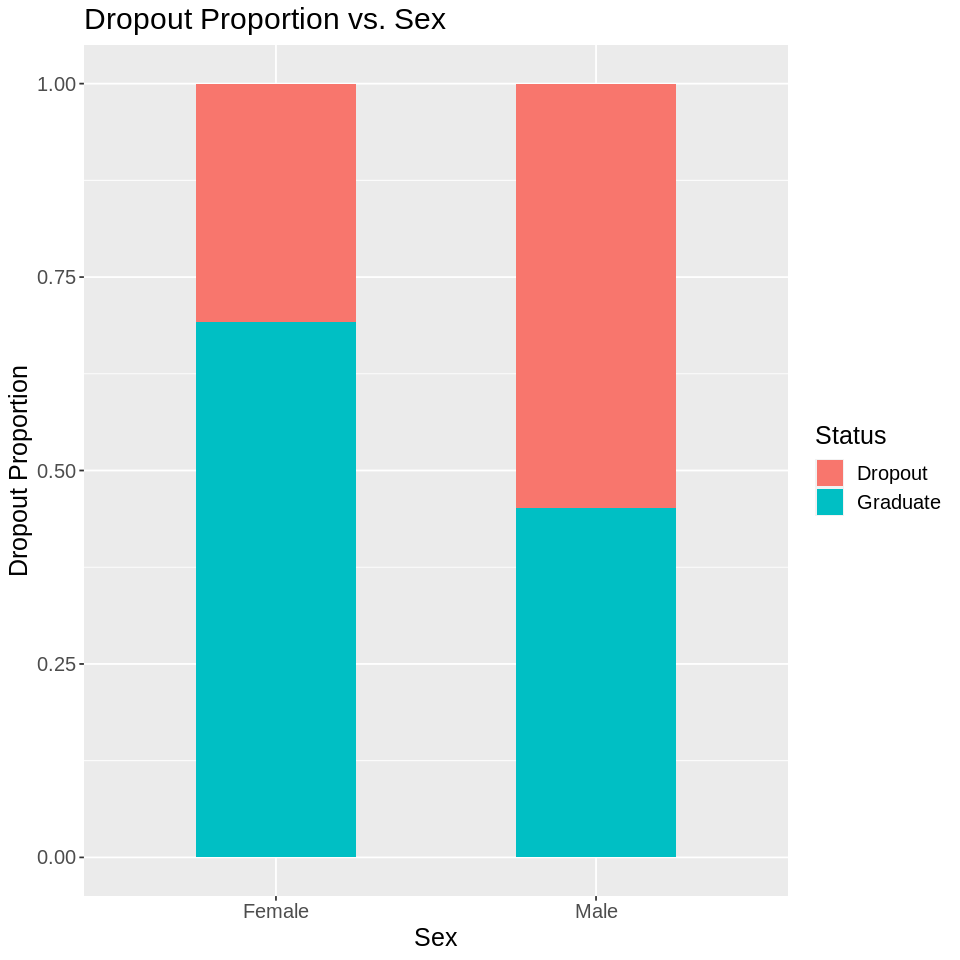

In [10]:
# graph 5: dropout proportion vs. sex
options(repr.plot.width = 8, repr.plot.height = 8)
proportion_bar_plot <- data_train |>
   mutate(gender = factor(gender, levels = c("0", "1"), labels = c("Female", "Male"))) |>
   ggplot(aes(x = gender, fill = status)) + 
   geom_bar(position = 'fill', width = 0.5) + 
   xlab("Sex") +
   ylab("Dropout Proportion") +
   labs(fill = "Status") +
   ggtitle("Dropout Proportion vs. Sex") +
   theme(text = element_text(size = 15))         
proportion_bar_plot

**Figure 7:** `insert figure explanation` 

## Methods
#### Choosing Predictors:
Four characteristics that may predict whether an individual will be a graduate or a dropout were chosen.

##### Gender
Studies have shown that females are more likely to graduate than males <sup> 1</sup>.

##### Age at Enrollment
Differences in experience and maturity at older ages may contribute to better academic performance.

##### 1st & 2nd Semester Grades (2 predictors)
Grades could be a predictor, as low grades can result in students choosing to drop out. Changes in grades from first to second semester could also influence students' decision of dropping out.  

The goal is to see if these predictors do indeed predict whether an individual will graduate or drop out and how well it predicts it.

##### 1. A recipe was created, specifying the label and predictors' columns and standardize the training dataset. 

In [29]:
data_recipe <- recipe(status ~ . , data = data_train)|>
step_scale(all_predictors())|>
step_center(all_predictors())

##### 2.

In [12]:
data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
set_engine("kknn")|>
set_mode("classification")

##### 3.

In [14]:
set.seed(1)

data_vfold <- vfold_cv(data_train, v = 5, strata = status)

##### 4. 
*From proposal: "Tune the model using the KNN algorithm and 5-fold validation to pick the best K value"*

In [52]:
k_vals <- tibble(neighbors = seq(1:500))

##### 5.

 *From proposal: "Perform a workflow analysis to fit the model for k values of 1-500."*

In [16]:
data_fit <- workflow()|>
add_model(data_spec)|>
add_recipe(data_recipe)|>
tune_grid(resamples = data_vfold, grid= k_vals)

##### 6.
 *From proposal: "Collect the estimated accuracies of each classifier created"*

In [17]:
data_accuracies<-data_fit|>
collect_metrics()|>
filter(.metric == "accuracy")
data_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7662581,5,0.010508473,Preprocessor1_Model01
2,accuracy,binary,0.7655228,5,0.011525091,Preprocessor1_Model02
3,accuracy,binary,0.7993335,5,0.011010424,Preprocessor1_Model03
4,accuracy,binary,0.8000688,5,0.010963138,Preprocessor1_Model04
5,accuracy,binary,0.8125627,5,0.008293425,Preprocessor1_Model05
6,accuracy,binary,0.8125627,5,0.007832423,Preprocessor1_Model06
7,accuracy,binary,0.8147646,5,0.011459346,Preprocessor1_Model07
8,accuracy,binary,0.8151322,5,0.011343285,Preprocessor1_Model08
9,accuracy,binary,0.8143989,5,0.010684361,Preprocessor1_Model09


##### 7.
 *From proposal: "create a line plot to choose the best K value"*

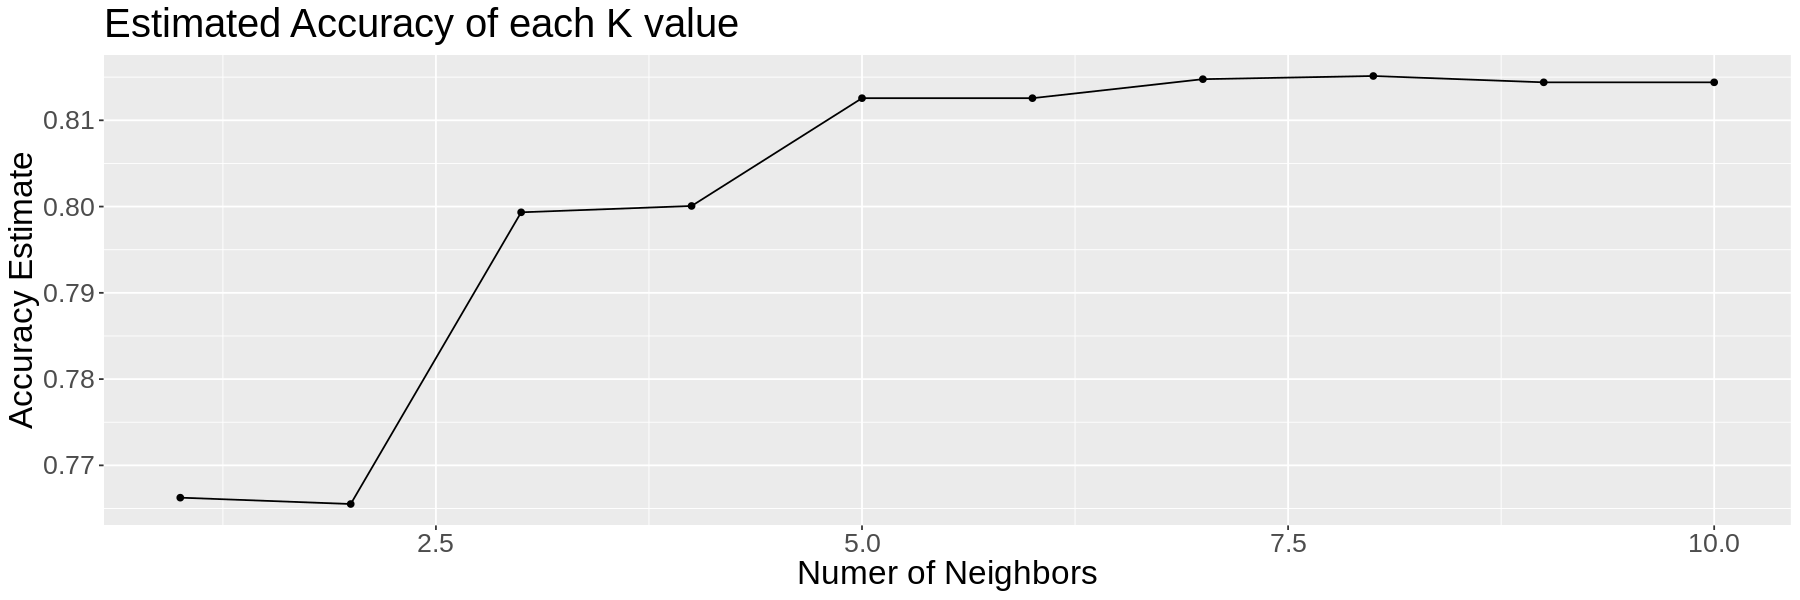

In [55]:
options(repr.plot.width= 15., repr.plot.height=5)

neighbor_accuracy_plot<- ggplot(data_accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Numer of Neighbors", y = "Accuracy Estimate") +
                  ggtitle("Estimated Accuracy of each K value")+
                  theme(text = element_text(size = 20)) 
neighbor_accuracy_plot

**Figure 8:** `insert figure explanation` 

##### 8. Best K value was chosen. 
 *explain why you chose that k value*

#### Retraining with best k (number of neighbors)!

##### 9.

In [58]:
data_spec_best <- nearest_neighbor(weight_func = “rectangular”, neighbor = ...)
set_engine(“kknn”)|>
set_mode(“classification”)

ERROR: Error in parse(text = x, srcfile = src): <text>:1:50: unexpected input
1: data_spec_best <- nearest_neighbor(weight_func = “
                                                     ^


##### 10. 

In [57]:
data_best_fit <- workflow()|>
add_model(data_spec_best)|>
add_recipe(data_recipe)|>
fit(data_train)

##### 11. 
*From proposal: "Test the trained model with the testing dataset."*

In [43]:
predictions<- predict(data_fit, data_train)|>
bind_cols(data_test)

##### 12. 
*From proposal: "Determine classifier’s accuracy."*

In [ ]:
data_metrics<- metrics(truth=status, estimate = .pred_class)|>
filter(.metric = “accuracy”)

##### 13. 

In [ ]:
data_conf_mat<- conf_mat(predictions, truth=status, estimate=.pred_class)

## Discussion

*summarize what you found\
discuss whether this is what you expected to find?\
discuss what impact could such findings have?\
discuss what future questions could this lead to?*

### *From Proposal: Expected outcomes and significance*
We expect the four chosen factors to collectively predict fairly well whether a student will be a graduate or a dropout. If there is indeed a correlation and the factors are collectively a good predictor, the created classifier could be used by students with matching factors to predict whether they will become a graduate or a dropout. Further studies could be done to analyze each factor’s significance on predicting students' future status (graduate or dropout) and determining why certain factor(s) could be more significant. If the classifier is high in accuracy, another question could be whether or not this model can be applied to elementary and high school students.

## References

Dataset: https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention?datasetId=2780494

<sup> 1</sup> https://www.brookings.edu/blog/up-front/2021/10/08/the-male-college-crisis-is-not-just-in-enrollment-but-completion/ \
<sup> 2</sup> 

## *Qs for Eddie!!!*

Layout
- do we have the orginal data set as figure 1? or does it not need to have a label?
- do we need to add title + explanations for tables used while tuning the model for classification? - like a caption for the accuracy table
- numbering process steps ok?
- figures labelling layout ok?

Referneces
- references -> literature as in research articles? or just websites, articles used?
- how do u cite a dataset? use kaggle?
- at least two citations --> including data set???